In [1]:
!pip install -q newsapi-python
!pip install -q -U google-generativeai

Number of articles that I'm going to analyze for you: 6
6/6<-Article Being Analyzed...[(0, 60), (3, 30)] [(0, 'Unknown-term'), (3, 'Short-term')]
[(0, 60), (3, 30)] [(3, 30)] []
avgs   {'Overall': 45.0, 'Short-term': 30, 'Mid-term': 50, 'Long-term': 50, 'Unknown-term': 60}


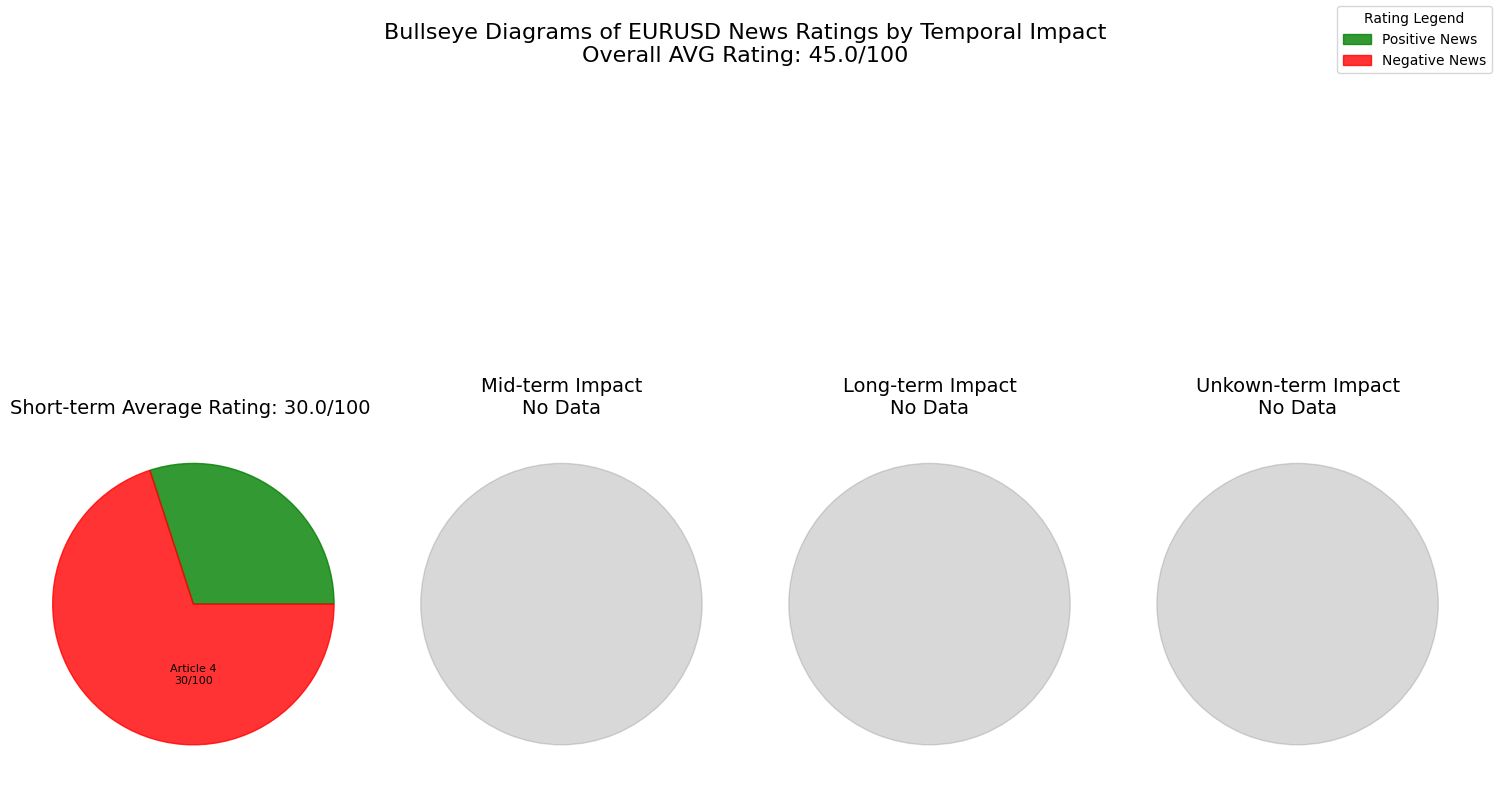

In [9]:
from enum import unique
import google.generativeai as genai
import os
import time
from newsapi import NewsApiClient
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Wedge

class News_Analyser:
    def __init__(self,ticker_name='eurusd', num_articles=100, ticker_type='forex', model='fast', terminal_print=False):
        self.newsapi = NewsApiClient(api_key='')
        genai.configure(api_key="")
        genai.configure(api_key="")
        genai.configure(api_key="")
        if model=='fast':
            model_name='models/gemini-1.0-pro'
        elif model=='heavy':
            model_name='models/gemini-1.5-pro'
        elif model=='very fast':
            model_name='models/gemini-1.0'
        self.model1, self.model2, self.model3 = genai.GenerativeModel(model_name), genai.GenerativeModel(model_name), genai.GenerativeModel(model_name)

        # for m in genai.list_models():
        #      if 'generateContent' in m.supported_generation_methods:
        #         print(m.name)

        self.ticker_name = ticker_name
        articles = self.get_forex_news(ticker_name.upper(),page_size=num_articles)
        print(f"Number of articles that I'm going to analyze for you: {len(articles)}")
        ratings, temporal_impacts = [], []
        for idx,article in enumerate(articles):
            prompt = f"""Analyze the following news article about the forex pair {ticker_name}. Follow these rules strictly:

                Rating System:
                    If the news is positive for {ticker_name[:3]} (e.g., EUR in EURUSD), increase the rating.
                    If the news is positive for {ticker_name[3:]} (e.g., USD in EURUSD), decrease the rating.
                    Use a scale of 0 to 100:
                        Above 50: Bullish for the first currency (e.g., EUR in EURUSD).
                        Below 50: Bearish for the first currency.
                        50: Neutral or insignificant news.

                Timeframe Classification:
                    Short-term: News likely to impact within days.
                    Mid-term: News likely to impact within weeks.
                    Long-term: News likely to impact over months or longer.

            Response format (strict):

                A single number (e.g., 85/100).
                One line summarizing the sentiment and the likely timeframe of the impact (e.g., "Positive outlook for EUR due to strong economic data, short-term impact.")
            Here’s the article: {article}"""

            LLM_Analysis = self.ask_LLM(prompt,model1=self.model1,model2=self.model2,model3=self.model3)
            if terminal_print is True:
                print(f"Article {idx+1}: \n{LLM_Analysis} \n{article['url']}")
            else:
                print(f"\r{idx+1}/{len(articles)}<-Article Being Analyzed...", end="", flush=True)
            try:
                if int(LLM_Analysis.split("/")[0]) == 50:
                    continue
                ratings.append((idx, int(LLM_Analysis.split("/")[0])))
                if 'short-term' in LLM_Analysis.lower() or 'short term' in LLM_Analysis.lower() or 'short' in LLM_Analysis.lower():
                    temporal_impacts.append((idx, 'Short-term'))
                elif 'mid-term' in LLM_Analysis.lower() or 'mid term' in LLM_Analysis.lower() or 'mid' in LLM_Analysis.lower():
                    temporal_impacts.append((idx, 'Mid-term'))
                elif 'long-term' in LLM_Analysis.lower() or 'long term' in LLM_Analysis.lower() or 'long' in LLM_Analysis.lower():
                    temporal_impacts.append((idx, 'Long-term'))
                else:
                    temporal_impacts.append((idx, 'Unknown-term'))
            except:
                #ratings.append((idx, 50))
                continue

        try:
            short_ratings = [(temporal_impacts[i][0], rating) for i, (idx, rating) in enumerate(ratings) if temporal_impacts[i][1] == 'Short-term']
        except:
            short_ratings = []
        try:
            mid_ratings = [(temporal_impacts[i][0], rating) for i, (idx, rating) in enumerate(ratings) if temporal_impacts[i][1] == 'Mid-term']
        except:
            mid_ratings = []
        try:
            long_ratings = [(temporal_impacts[i][0], rating) for i, (idx, rating) in enumerate(ratings) if temporal_impacts[i][1] == 'Long-term']
        except:
            long_ratings = []
        try:
            unknown_ratings = [(temporal_impacts[i][0], rating) for i, (idx, rating) in enumerate(ratings) if temporal_impacts[i][1] == 'Unknown-term']
        except:
            unknown_ratings = []

        self.average_dict = {'Overall': self.calculate_average_rating(ratings), 'Short-term': self.calculate_average_rating(short_ratings), 'Mid-term': self.calculate_average_rating(mid_ratings), 'Long-term': self.calculate_average_rating(long_ratings), 'Unknown-term': self.calculate_average_rating(unknown_ratings)}
        temp_impacts = [i[1] for i in temporal_impacts]
        self.plot_bullseye_diagrams(ratings, temp_impacts)

    def ask_LLM(self, query,model1,model2,model3):
        try:
            response = model1.generate_content(query)
        except:
            try:
                response = model2.generate_content(query)
            except:
                try:
                    response = model3.generate_content(query)
                except:
                    print("Waiting for api to cool down...")
                    time.sleep(30)
                    return "50/100 No analysis"
        return response.text

    def calculate_average_rating(self, ratings):
        if len(ratings) > 1:
            total_rating = sum(rating for _, rating in ratings)
            average_rating = total_rating / len(ratings)
            return average_rating
        elif len(ratings) == 1:
            return ratings[0][1]
        else:
            return 50
    def get_forex_news(self, pair, page_size=100, num_pages=1):
        query1, query2, query3 = pair, pair[:3], pair[3:]
        articles_details1, articles_details2, articles_details3 = [], [], []

        for page in range(1, num_pages + 1):
            news = self.newsapi.get_everything(q=query1,language='en',sort_by='publishedAt',page_size=page_size,page=page)
            if not news['articles']:
                print(f"No articles found for page {page}.")
                os._exit(0)
                break
            for article in news['articles']:
                articles_details1.append({"title": article['title'],"url": article['url'],"date": article['publishedAt'],"content": article.get('content', 'Content not available')})

        for page in range(1, num_pages + 1):
            news = self.newsapi.get_everything(q=query2,language='en',sort_by='publishedAt',page_size=page_size,page=page)
            if not news['articles']:
                print(f"No articles found for page {page}.")
                os._exit(0)
                break
            for article in news['articles']:
                articles_details2.append({"title": article['title'],"url": article['url'],"date": article['publishedAt'],"content": article.get('content', 'Content not available')})

        for page in range(1, num_pages + 1):
            news = self.newsapi.get_everything(q=query3,language='en',sort_by='publishedAt',page_size=page_size,page=page)
            if not news['articles']:
                print(f"No articles found for page {page}.")
                os._exit(0)
                break
            for article in news['articles']:
                articles_details3.append({"title": article['title'],"url": article['url'],"date": article['publishedAt'],"content": article.get('content', 'Content not available')})

        articles_details, loop_length = [] , max(len(articles_details1),len(articles_details2),len(articles_details3))
        for i in range(loop_length):
            try:
                if articles_details1[i]['url'] == articles_details2[i]['url'] == articles_details3[i]['url']:
                    articles_details.append(articles_details1[i])
                elif articles_details1[i]['url'] == articles_details2[i]['url']:
                    articles_details.append(articles_details1[i])
                elif articles_details1[i]['url'] == articles_details3[i]['url']:
                    articles_details.append(articles_details1[i])
                elif articles_details3[i]['url'] == articles_details2[i]['url']:
                    articles_details.append(articles_details3[i])
                else:
                    articles_details.append(articles_details1[i])
                    articles_details.append(articles_details2[i])
                    articles_details.append(articles_details3[i])
            except:
                try:
                    articles_details.append(articles_details1[i])
                except:
                    pass
                try:
                    articles_details.append(articles_details2[i])
                except:
                    pass
                try:
                    articles_details.append(articles_details3[i])
                except:
                    pass
        return articles_details

    def plot_bullseye_diagrams(self, ratings, temporal_impacts):
        unique_temporal_impacts = ['Short-term', 'Mid-term', 'Long-term', 'Unkown-term']#set(temporal_impacts)
        num_subplots = len(unique_temporal_impacts)
        fig, axes = plt.subplots(1, num_subplots, figsize=(15, 10), subplot_kw={'aspect': 'equal'})

        if num_subplots == 1:  # If there's only one unique temporal impact
            axes = [axes]
        max_radius = 5
        for ax, temporal_impact in zip(axes, unique_temporal_impacts):
            filtered_ratings = []
            for (idx, rating), impact in zip(ratings, temporal_impacts):
                if impact == temporal_impact:
                    filtered_ratings.append((idx, rating))
            total_articles = len(filtered_ratings)
            if total_articles == 0:
                        ax.set_xlim(-max_radius * 1.3, max_radius * 1.3)
                        ax.set_ylim(-max_radius * 1.3, max_radius * 1.3)
                        ax.add_patch(Wedge((0, 0), max_radius, 0, 360, color='gray', alpha=0.3, label="No Articles"))
                        ax.set_title(f"{temporal_impact.capitalize()} Impact\nNo Data", fontsize=14)
                        ax.axis('off')
                        continue

            radius_step = max_radius / total_articles
            ax.axis('off')
            for i, (idx, rating) in enumerate(filtered_ratings):
                percentage = rating / 100
                outer_radius = max_radius - i * radius_step
                inner_radius = outer_radius - radius_step
                theta1 = 0
                theta2_green = 360 * percentage  # Angle for green
                theta2_red = 360  # Full circle for red

                green_wedge = Wedge((0, 0), outer_radius, theta1, theta2_green, width=radius_step, color='green', alpha=0.8)
                ax.add_patch(green_wedge)
                red_wedge = Wedge((0, 0), outer_radius, theta2_green, theta2_red, width=radius_step, color='red', alpha=0.8)
                ax.add_patch(red_wedge)

                label_radius = (outer_radius + inner_radius) / 2
                ax.text(0, -label_radius, f"Article {idx + 1}\n{rating}/100", color="black", fontsize=8, ha="center", va="center")

            ax.set_xlim(-max_radius * 1.3, max_radius * 1.3)
            ax.set_ylim(-max_radius * 1.3, max_radius * 1.3)
            ax.set_title(f"{temporal_impact} Average Rating: {self.average_dict[temporal_impact]:.1f}/100 ", fontsize=14)

        legend_patches = [Wedge((0, 0), 1, 0, 180, color='green', alpha=0.8, label="Positive News"),Wedge((0, 0), 1, 180, 360, color='red', alpha=0.8, label="Negative News"),]
        fig.legend(handles=legend_patches, loc="upper right", fontsize=10, title="Rating Legend")
        plt.suptitle(f"Bullseye Diagrams of {self.ticker_name.upper()} News Ratings by Temporal Impact \n\n Overall AVG Rating: {self.average_dict['Overall']:.1f}/100", fontsize=16)
        plt.tight_layout()
        plt.show()

news_analysis_tool = News_Analyser(ticker_name='eurusd', num_articles=10, model='fast')

